##Árvore de regressão (ajuste)

In [31]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

In [32]:
#Carregando o conjunto de dados
boston=fetch_openml(name='boston',as_frame=True)
dados=boston.data
dados['MEDV']=boston.target
dados.head()

/usr/local/lib/python3.12/dist-packages/sklearn/datasets/_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=531
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=853

  warn(warning_msg)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [33]:
# Treinamento, validação e ajuste do modelo

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

In [35]:
# Particionar o conjunto de dados (treinamento e validação)
x_train,x_test,y_train,y_test=train_test_split(dados.drop('MEDV',axis=1),dados['MEDV'],test_size=0.2,random_state=1)

In [36]:
#Ajuste de uma árvore alterando valores default
mod1=DecisionTreeRegressor(random_state=1,min_samples_leaf=5,min_samples_split=20,max_depth=4)
mod1.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=20,
                      random_state=1)

In [37]:
# Resumo (apenas uma variável foi utilizada na construção da árvore)
print(mod1)
print('Features importantes: ',mod1.feature_importances_)
print(dados.columns)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=20,
                      random_state=1)
Features importantes:  [0.01847094 0.         0.00716072 0.         0.0744294  0.25808278
 0.01161429 0.00449766 0.         0.         0.01992293 0.
 0.60582129]
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')


In [38]:
# Criar o dataframe com as importancias: [:-1] significa "selecione todos os elementos da sequência exceto o ú8ltimo"
imp=pd.DataFrame({'Features':dados.columns[:-1],'Importancia':mod1.feature_importances_})
# Imprimir o DataFrame
print(imp)

   Features  Importancia
0      CRIM     0.018471
1        ZN     0.000000
2     INDUS     0.007161
3      CHAS     0.000000
4       NOX     0.074429
5        RM     0.258083
6       AGE     0.011614
7       DIS     0.004498
8       RAD     0.000000
9       TAX     0.000000
10  PTRATIO     0.019923
11        B     0.000000
12    LSTAT     0.605821


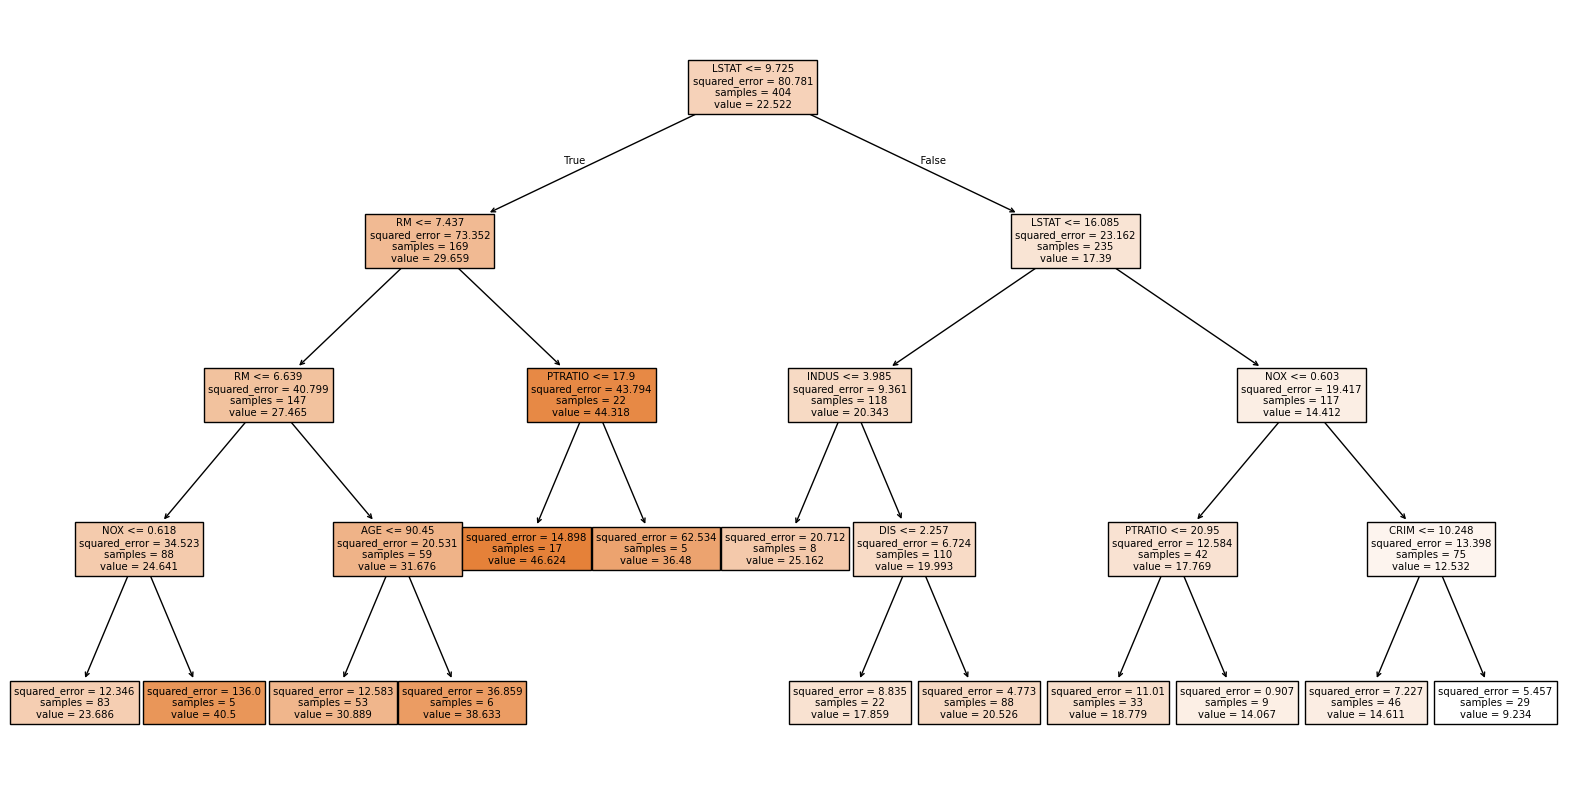

In [39]:
#Apresentação da árvore ajustada
plt.figure(figsize=(20,10))
plot_tree(mod1,filled=True,feature_names=x_train.columns)
plt.show()

## Árvore de regressão (poda)

In [40]:
## Poda#
#Poda da árvore (em python a poda é feita com ccp_alpha)
path=mod1.cost_complexity_pruning_path(x_train,y_train)
cpp_alphas,impurities=path.ccp_alphas,path.impurities

In [41]:
# Encontrar o melhor ccp_alpha (equivalente ao best=6 no R)
best_ccp_alpha=cpp_alphas[np.argmin(impurities)] #encontrar o alpha com o menor impurity
best_ccp_alpha
mod_poda=DecisionTreeRegressor(random_state=1,ccp_alpha=best_ccp_alpha,min_samples_leaf=5,min_samples_split=20,max_depth=4)
mod_poda.fit(x_train,y_train)


DecisionTreeRegressor(ccp_alpha=np.float64(0.0), max_depth=4,
                      min_samples_leaf=5, min_samples_split=20, random_state=1)

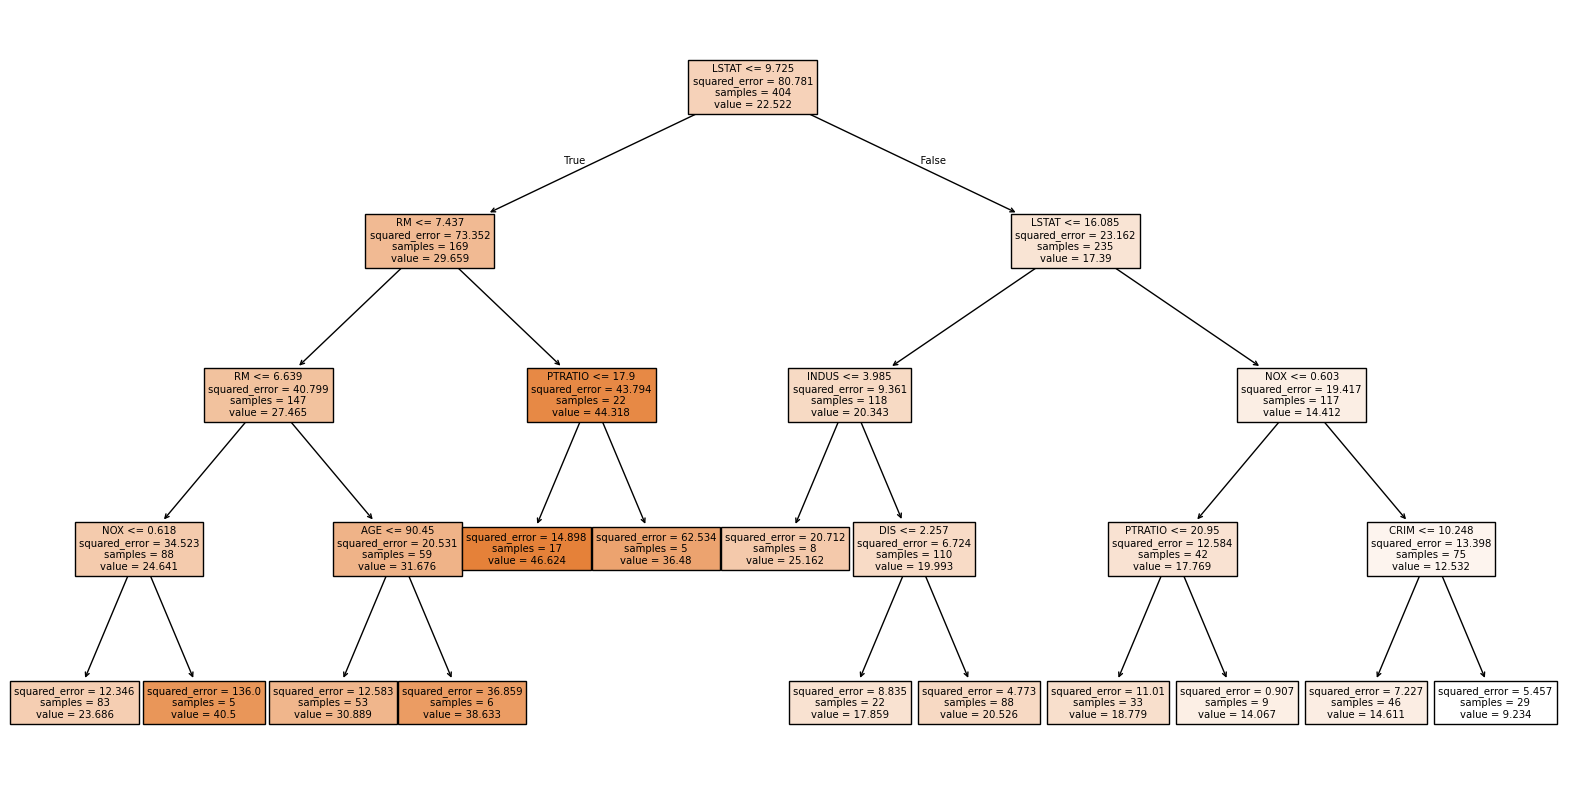

In [42]:
# Apresentação da árvore podada

plt.figure(figsize=(20,10))
plot_tree(mod_poda,filled=True,feature_names=x_train.columns)
plt.show()

In [43]:
# Predição (considerando o modelo sem poda)
yhat=mod1.predict(x_test)
boston_test=y_test

In [44]:
# Calcular o RMSE (Raiz do erro quadrático médio)
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(boston_test,yhat))
print('RMSE: ',rmse)

RMSE:  4.455533348105255


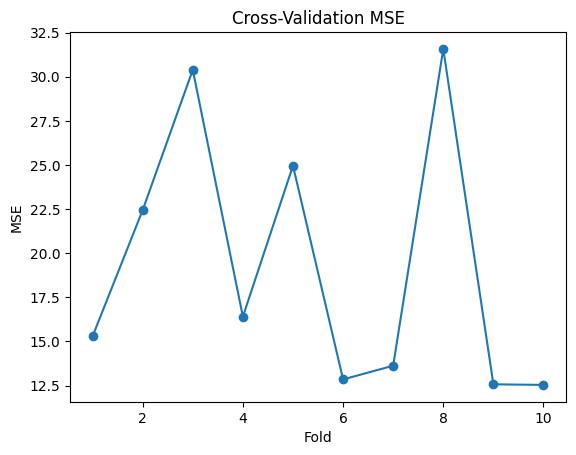

In [45]:
# Estudo de validação cruzada

cv_scores=cross_val_score(mod1,x_train,y_train,cv=10,scoring='neg_mean_squared_error')
cv_mse=-cv_scores #pega o valor positivo do mse
plt.plot(range(1,11),cv_mse,marker='o') #plota os valores do cross validation
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Cross-Validation MSE')
plt.show()

In [46]:
print('Média do MSE: ',np.mean(cv_mse))
print('Desvio padrão do MSE: ',np.std(cv_mse))

Média do MSE:  19.26360606513066
Desvio padrão do MSE:  7.106379528196517


## Árvore de regressão (bagging e randomforest)

In [47]:
#Bagging
from sklearn.ensemble import RandomForestRegressor


In [48]:
# Bagging using RandomForetRegressor (mtry=13 means all features

mod_bag= RandomForestRegressor(n_estimators=100,max_features=13,random_state=1) # random_state
mod_bag.fit(x_train,y_train)

RandomForestRegressor(max_features=13, random_state=1)

In [49]:
# Model evaluation (Prediction)
yhat_bag=mod_bag.predict(x_test)
rmse_bag=np.sqrt(mean_squared_error(y_test,yhat_bag))
print(f'RMSE_bag: {rmse_bag}')

RMSE_bag: 2.9860173226189413


In [50]:
# Random Forest

mod_rf=RandomForestRegressor(n_estimators=100,max_features=4,random_state=1)
mod_rf.fit(x_train,y_train)



RandomForestRegressor(max_features=4, random_state=1)

In [51]:
# Predictions

yhat_rf=mod_rf.predict(x_test)

In [52]:
# RMSE

rmse_rf=np.sqrt(mean_squared_error(y_test,yhat_rf))
print(f'RMSE_rf: {rmse_rf}')


RMSE_rf: 3.1506317589321933


In [53]:
# Criar DataFrame com os valores do RMSE

In [54]:
rmse_data={'Modelo':['Regressão','Bagging','Random Forest'],'RMSE':[rmse,rmse_bag,rmse_rf]}
rmse_df=pd.DataFrame(rmse_data)
print(rmse_df)

          Modelo      RMSE
0      Regressão  4.455533
1        Bagging  2.986017
2  Random Forest  3.150632


In [55]:
# Feature importance Bagging
i_mod_bag=mod_bag.feature_importances_
print('Feature Importance: ')
for feature, importance in zip(x_train.columns,i_mod_bag):
  print(f'{feature}: {importance}')

Feature Importance: 
CRIM: 0.04026782402211185
ZN: 0.0009627868598930243
INDUS: 0.00822586136370901
CHAS: 0.0008354702225570655
NOX: 0.026228319000521874
RM: 0.278027492822481
AGE: 0.01939696739026326
DIS: 0.0652787065477574
RAD: 0.0037785432307005577
TAX: 0.013418678105155617
PTRATIO: 0.019411772941481588
B: 0.01394795267108449
LSTAT: 0.5102196248222832


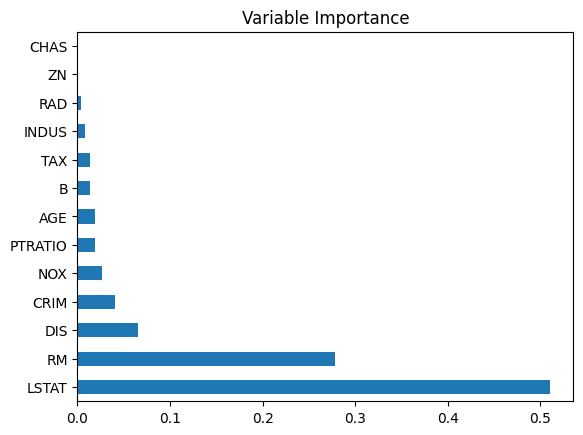

In [56]:
# Variable Importance Plot

feature_importances=pd.Series(i_mod_bag,index=x_train.columns)
feature_importances.nlargest(13).plot(kind='barh') # 13 features in Boston dataset
plt.title('Variable Importance')
plt.show()